This notebook creates and compare three models for the "Finance Factoring - IBM Late Payment Histories" dataset to predict whether an invoice is paid late.

# <b>1 <span style='color:#886ce4'>|</span> Import libraries</b>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/finance-factoring-ibm-late-payment-histories/WA_Fn-UseC_-Accounts-Receivable.csv


# <b>2 <span style='color:#886ce4'>|</span> Reading Data</b>

In [2]:
df = pd.read_csv('/kaggle/input/finance-factoring-ibm-late-payment-histories/WA_Fn-UseC_-Accounts-Receivable.csv')
df.head()

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate
0,391,0379-NEVHP,4/6/2013,611365,1/2/2013,2/1/2013,55.94,No,1/15/2013,Paper,13,0
1,406,8976-AMJEO,3/3/2012,7900770,1/26/2013,2/25/2013,61.74,Yes,3/3/2013,Electronic,36,6
2,391,2820-XGXSB,1/26/2012,9231909,7/3/2013,8/2/2013,65.88,No,7/8/2013,Electronic,5,0
3,406,9322-YCTQO,4/6/2012,9888306,2/10/2013,3/12/2013,105.92,No,3/17/2013,Electronic,35,5
4,818,6627-ELFBK,11/26/2012,15752855,10/25/2012,11/24/2012,72.27,Yes,11/28/2012,Paper,34,4


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466 entries, 0 to 2465
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   countryCode    2466 non-null   int64  
 1   customerID     2466 non-null   object 
 2   PaperlessDate  2466 non-null   object 
 3   invoiceNumber  2466 non-null   int64  
 4   InvoiceDate    2466 non-null   object 
 5   DueDate        2466 non-null   object 
 6   InvoiceAmount  2466 non-null   float64
 7   Disputed       2466 non-null   object 
 8   SettledDate    2466 non-null   object 
 9   PaperlessBill  2466 non-null   object 
 10  DaysToSettle   2466 non-null   int64  
 11  DaysLate       2466 non-null   int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 231.3+ KB


> * The data is divided into 7 features of the Object type, 4 features of the Int type and only one type of float.
> * There is no missing data.

# <b>3 <span style='color:#886ce4'>|</span> Data Engineering</b>

## 3.1 Date Format

In [4]:
cols_date = ["PaperlessDate","InvoiceDate","DueDate","SettledDate"]
for col in cols_date:
    df[col] = pd.to_datetime(df[col],format='%m/%d/%Y')
df.head()

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate
0,391,0379-NEVHP,2013-04-06,611365,2013-01-02,2013-02-01,55.94,No,2013-01-15,Paper,13,0
1,406,8976-AMJEO,2012-03-03,7900770,2013-01-26,2013-02-25,61.74,Yes,2013-03-03,Electronic,36,6
2,391,2820-XGXSB,2012-01-26,9231909,2013-07-03,2013-08-02,65.88,No,2013-07-08,Electronic,5,0
3,406,9322-YCTQO,2012-04-06,9888306,2013-02-10,2013-03-12,105.92,No,2013-03-17,Electronic,35,5
4,818,6627-ELFBK,2012-11-26,15752855,2012-10-25,2012-11-24,72.27,Yes,2012-11-28,Paper,34,4


Replace all dates to the number of days passed since January 1st 2012.

In [5]:
def calc_timeDelta(df, col):
    return (df[col] - datetime(2012, 1, 1)) / np.timedelta64(1, 'D')

df["PaperlessDate"] = calc_timeDelta(df, "PaperlessDate")
df["InvoiceDate"] = calc_timeDelta(df, "InvoiceDate")
df["DueDate"] = calc_timeDelta(df, "DueDate")
df.head()

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate
0,391,0379-NEVHP,461.0,611365,367.0,397.0,55.94,No,2013-01-15,Paper,13,0
1,406,8976-AMJEO,62.0,7900770,391.0,421.0,61.74,Yes,2013-03-03,Electronic,36,6
2,391,2820-XGXSB,25.0,9231909,549.0,579.0,65.88,No,2013-07-08,Electronic,5,0
3,406,9322-YCTQO,96.0,9888306,406.0,436.0,105.92,No,2013-03-17,Electronic,35,5
4,818,6627-ELFBK,330.0,15752855,298.0,328.0,72.27,Yes,2012-11-28,Paper,34,4


3.2 Remove invoiceNumber attribute because this information may not be relevant for the model

In [6]:
df = df.drop(["invoiceNumber"], axis=1)

3.3 Transform countryCode attribute to columns

In [7]:
# List of countries
countryCode_list=df['countryCode'].unique()

# One-hot encoding
oneHotCountry = pd.get_dummies(df['countryCode'])
df = df.join(oneHotCountry)
df = df.drop('countryCode',axis = 1)


# rename columns
for col in countryCode_list:
    df.rename(columns={col: 'Country_'+str(col)}, inplace=True)
    
df.head()

,customerID,PaperlessDate,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate,Country_391,Country_406,Country_770,Country_818,Country_897
0,0379-NEVHP,461.0,367.0,397.0,55.94,No,2013-01-15,Paper,13,0,1,0,0,0,0
1,8976-AMJEO,62.0,391.0,421.0,61.74,Yes,2013-03-03,Electronic,36,6,0,1,0,0,0
2,2820-XGXSB,25.0,549.0,579.0,65.88,No,2013-07-08,Electronic,5,0,1,0,0,0,0
3,9322-YCTQO,96.0,406.0,436.0,105.92,No,2013-03-17,Electronic,35,5,0,1,0,0,0
4,6627-ELFBK,330.0,298.0,328.0,72.27,Yes,2012-11-28,Paper,34,4,0,0,0,1,0


3.4 Map customer ID

In [8]:
unique_customerID = df['customerID'].unique()
customerID_map = {u: i for i, u in enumerate(unique_customerID)}
df.customerID = df.customerID.map(customerID_map)
df.head()

,customerID,PaperlessDate,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate,Country_391,Country_406,Country_770,Country_818,Country_897
0,0,461.0,367.0,397.0,55.94,No,2013-01-15,Paper,13,0,1,0,0,0,0
1,1,62.0,391.0,421.0,61.74,Yes,2013-03-03,Electronic,36,6,0,1,0,0,0
2,2,25.0,549.0,579.0,65.88,No,2013-07-08,Electronic,5,0,1,0,0,0,0
3,3,96.0,406.0,436.0,105.92,No,2013-03-17,Electronic,35,5,0,1,0,0,0
4,4,330.0,298.0,328.0,72.27,Yes,2012-11-28,Paper,34,4,0,0,0,1,0


3.5 Map Disputed ad PaperLessBill attribute

In [9]:
Disputed_map = {'No': 0, 'Yes': 1}
df.Disputed = df.Disputed.map(Disputed_map)

PaperlessBill_map = {'Paper': 0, 'Electronic': 1}
df.PaperlessBill = df.PaperlessBill.map(PaperlessBill_map)
df.head()

,customerID,PaperlessDate,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate,Country_391,Country_406,Country_770,Country_818,Country_897
0,0,461.0,367.0,397.0,55.94,0,2013-01-15,0,13,0,1,0,0,0,0
1,1,62.0,391.0,421.0,61.74,1,2013-03-03,1,36,6,0,1,0,0,0
2,2,25.0,549.0,579.0,65.88,0,2013-07-08,1,5,0,1,0,0,0,0
3,3,96.0,406.0,436.0,105.92,0,2013-03-17,1,35,5,0,1,0,0,0
4,4,330.0,298.0,328.0,72.27,1,2012-11-28,0,34,4,0,0,0,1,0


3.6 Prepare dataframes for modeling approaches

Build target column "paidLate"
> * 0: Invoice is paid on time
> * 1: invoice is paid late

In [10]:
def const_paidLate(df):
    df['paidLate'] = (df['DaysLate'] > 0)*1
    return df

df = const_paidLate(df)
df.head()


,customerID,PaperlessDate,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate,Country_391,Country_406,Country_770,Country_818,Country_897,paidLate
0,0,461.0,367.0,397.0,55.94,0,2013-01-15,0,13,0,1,0,0,0,0,0
1,1,62.0,391.0,421.0,61.74,1,2013-03-03,1,36,6,0,1,0,0,0,1
2,2,25.0,549.0,579.0,65.88,0,2013-07-08,1,5,0,1,0,0,0,0,0
3,3,96.0,406.0,436.0,105.92,0,2013-03-17,1,35,5,0,1,0,0,0,1
4,4,330.0,298.0,328.0,72.27,1,2012-11-28,0,34,4,0,0,0,1,0,1


Remove "SettledDate", "DaysToSettle" and "DaysLate", because these features would directly give information about late payments to the model

In [11]:
def drop_settleCols(df):
    df = df.drop(["SettledDate","DaysToSettle","DaysLate"], axis=1)
    return df

df = drop_settleCols(df)
df.head()

,customerID,PaperlessDate,InvoiceDate,DueDate,InvoiceAmount,Disputed,PaperlessBill,Country_391,Country_406,Country_770,Country_818,Country_897,paidLate
0,0,461.0,367.0,397.0,55.94,0,0,1,0,0,0,0,0
1,1,62.0,391.0,421.0,61.74,1,1,0,1,0,0,0,1
2,2,25.0,549.0,579.0,65.88,0,1,1,0,0,0,0,0
3,3,96.0,406.0,436.0,105.92,0,1,0,1,0,0,0,1
4,4,330.0,298.0,328.0,72.27,1,0,0,0,0,1,0,1


Separate target for predictions

In [12]:
X = df.drop(['paidLate'], axis=1)
y = df.paidLate
# df.drop(['paidLate'], axis=1, inplace=True)
df.shape

(2466, 13)

Now split data into training and test datasets

In [13]:
# Break off validation set from training data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
print('Trainging dataset shape: ', X_train.shape)
print('Test dataset shape: ', X_test.shape)
X_train

Trainging dataset shape:  (1972, 12)
Test dataset shape:  (494, 12)


,customerID,PaperlessDate,InvoiceDate,DueDate,InvoiceAmount,Disputed,PaperlessBill,Country_391,Country_406,Country_770,Country_818,Country_897
616,70,428.0,457.0,487.0,63.00,0,1,0,0,1,0,0
2208,60,212.0,443.0,473.0,66.60,0,1,0,0,1,0,0
977,40,142.0,359.0,389.0,27.00,0,1,1,0,0,0,0
1414,42,76.0,112.0,142.0,72.32,1,1,0,1,0,0,0
11,11,254.0,584.0,614.0,73.35,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1033,47,236.0,421.0,451.0,88.67,1,1,0,1,0,0,0
1731,60,212.0,177.0,207.0,68.12,0,0,0,0,1,0,0
763,79,485.0,374.0,404.0,65.81,0,0,0,0,1,0,0
835,80,606.0,589.0,619.0,49.31,1,0,0,0,0,1,0


On time: 65.06085192697769 %, Late: 34.93914807302232 %


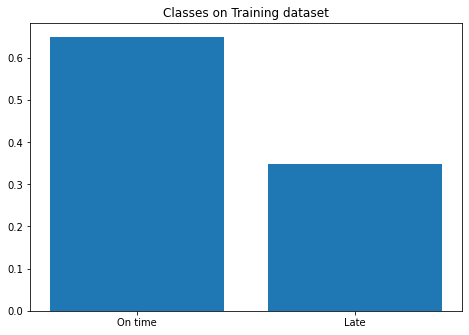

In [14]:
OnTime_train = y_train[y_train==0].count() / y_train.count()
Late_train = y_train[y_train==1].count() / y_train.count()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(['On time', 'Late'], [OnTime_train, Late_train])
plt.title('Classes on Training dataset')

print("On time:",OnTime_train*100,"%, Late:",Late_train*100,"%")

On time: 61.943319838056674 %, Late: 38.05668016194332 %


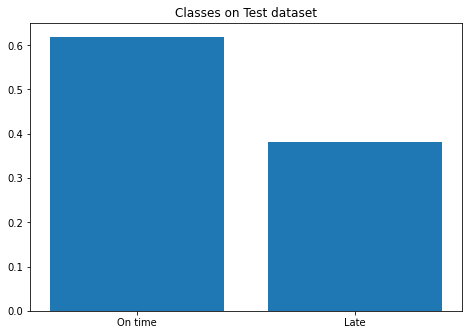

In [15]:
OnTime_test = y_test[y_test==0].count() / y_test.count()
Late_test = y_test[y_test==1].count() / y_test.count()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(['On time', 'Late'], [OnTime_test, Late_test])
plt.title('Classes on Test dataset')

print("On time:",OnTime_test*100,"%, Late:",Late_test*100,"%")

# <b>4 <span style='color:#886ce4'>|</span> Modeling approaches</b>

4.1 Decision Tree Classifier

The Accuracy for DecisionTreeClassifier is:  81  %


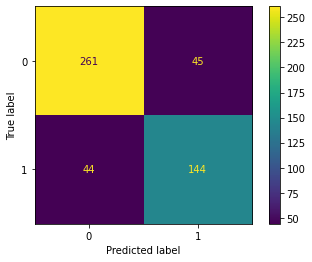

In [16]:
tree = tree.DecisionTreeClassifier()
tree = tree.fit(X_train, y_train)

predicted_tree = tree.predict(X_test)

ac_tree = accuracy_score(y_test, predicted_tree)
print('The Accuracy for DecisionTreeClassifier is: ', int(ac_tree * 100), " %")

cm = confusion_matrix(y_test, predicted_tree, labels=tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree.classes_)
disp.plot()

4.2 XGBoost Classifier

The Accuracy for XGBClassifier is:  87  %


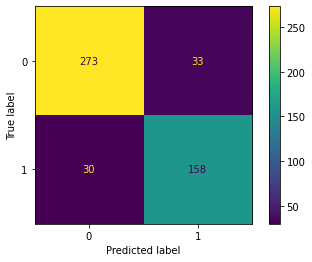

In [17]:
xgb = XGBClassifier(random_state=0,
                    n_estimators=1000,
                    max_depth=3,
                    learning_rate=0.1,
                    objective='binary:logistic',
                    verbosity=0,
                    use_label_encoder=False)

xgb = xgb.fit(X_train, y_train)

predicted_xgb = xgb.predict(X_test)

ac_xgb = accuracy_score(y_test, predicted_xgb)
print('The Accuracy for XGBClassifier is: ', int(ac_xgb * 100), " %")

cm = confusion_matrix(y_test, predicted_xgb, labels=xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_)
disp.plot()

4.3 LogisticRegression

The Accuracy for LogisticRegression is:  72  %


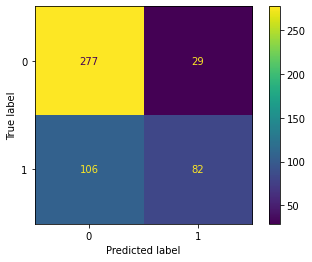

In [18]:
logr = LogisticRegression(random_state=0,solver='liblinear',penalty='l1',C=100,class_weight=None,max_iter=250)
logr.fit(X_train, y_train)

predicted_logr = logr.predict(X_test)
ac_logr = accuracy_score(y_test, predicted_logr)
print('The Accuracy for LogisticRegression is: ', int(ac_logr * 100), " %")

cm = confusion_matrix(y_test, predicted_logr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logr.classes_)
disp.plot()

4.4 Compare models output

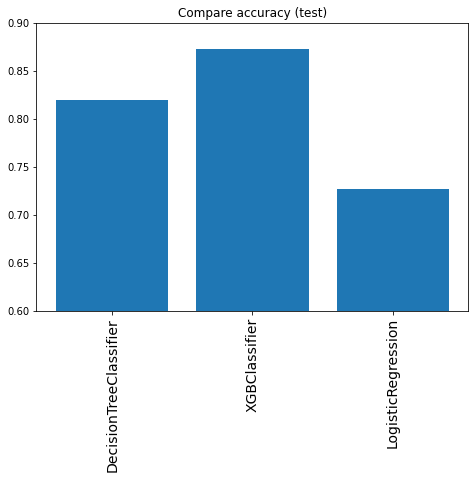

In [19]:
accuracies = [ac_tree, ac_xgb, ac_logr]
models_name = ['DecisionTreeClassifier', 'XGBClassifier', 'LogisticRegression']

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(models_name,accuracies)
_ = plt.xticks(rotation=90,fontsize=14)
plt.title('Compare accuracy (test)')
plt.ylim(0.60, 0.90)
plt.show()
